# Laboratorio 2
Ignacio Mendez (22613) y Diego Soto (22737)

Link al repositorio de GitHub: https://github.com/ignaciomendeza/VPC-LAB2.git

Carga de librerias

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


## Task 1

Carga de imagen periodic noise

In [2]:
imagen_periodic = cv2.imread("periodic_noise.jpg", cv2.IMREAD_GRAYSCALE)

Calculo de transformada de fourier discreta y shift en 0

In [3]:
imagen_f = imagen_periodic.astype(np.float32)

transformada_fourier = np.fft.fft2(imagen_f)

fourier_shift = np.fft.fftshift(transformada_fourier)

Calculo de versión logaritmica y grafica

In [4]:
magnitud = np.abs(fourier_shift)

logaritmica = np.log(1+magnitud)

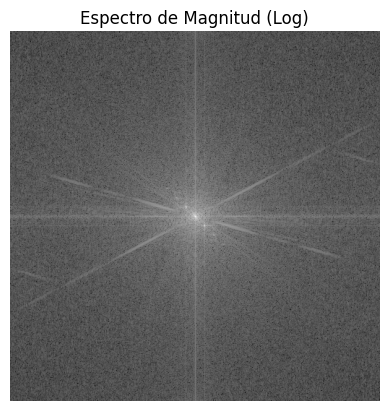

In [5]:
plt.imshow(logaritmica, cmap='gray')
plt.title("Espectro de Magnitud (Log)")
plt.axis('off')
plt.show()


In [6]:
# Funcion de mascara con lineas simetricas
def notch_lines_mask(shape, angles_deg, half_width=5, r_protect=12):

    H, W = shape
    cy, cx = H // 2, W // 2

    Y, X = np.ogrid[:H, :W]
    y = Y - cy
    x = X - cx

    # máscara inicial
    mask = np.ones((H, W), dtype=np.float32)

    r2 = x*x + y*y
    protect = r2 <= (r_protect * r_protect)

    for ang in angles_deg:
        theta = np.deg2rad(ang)

        dist = np.abs(x*np.sin(theta) - y*np.cos(theta))

        band = dist <= half_width

        mask[band & (~protect)] = 0.0

    mask[protect] = 1.0
    return mask


In [7]:
mask = notch_lines_mask(imagen_periodic.shape, angles_deg=[17, -28], half_width=0, r_protect=12)
F_filt = fourier_shift * mask


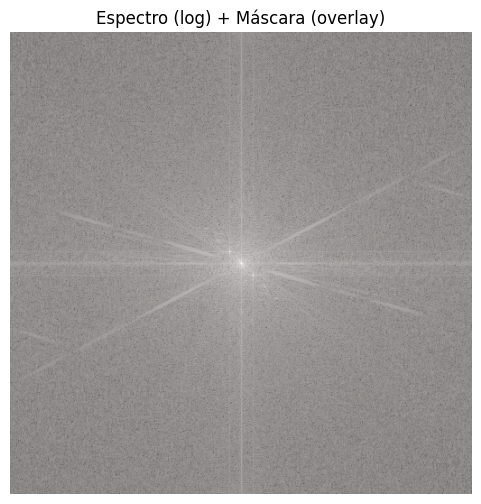

In [8]:
# Imagen del espectro con mascara 
plt.figure(figsize=(6,6))
plt.imshow(logaritmica, cmap='gray')
plt.imshow(mask, cmap='Reds', alpha=0.35)  
plt.title("Espectro (log) + Máscara (overlay)")
plt.axis('off')
plt.show()


In [9]:
# Función de mascara para puntos especificos
def add_circular_notches(mask, centers, radius=4):

    H, W = mask.shape
    Y, X = np.ogrid[:H, :W]

    for (cy, cx) in centers:
        circle = (Y - cy)**2 + (X - cx)**2 <= radius**2
        mask[circle] = 0.0

    return mask


In [10]:
# Colocación de puntos especificos
H, W = imagen_periodic.shape
cy, cx = H // 2, W // 2

extra_peaks = [
    (cy - 14, cx - 14),
    (cy + 14, cx + 14),

]

mask = add_circular_notches(mask, extra_peaks, radius=3)


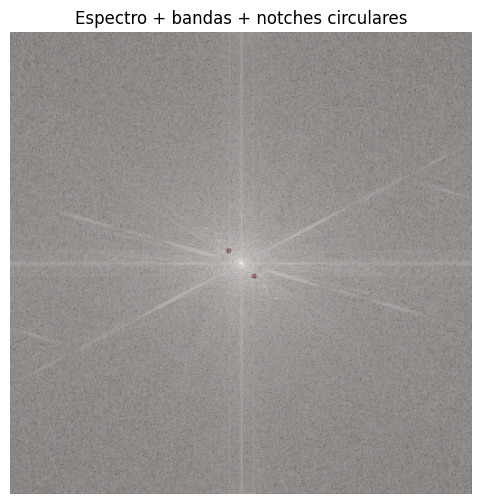

In [11]:
# Representación de puntos agregados en mascara
blocked = 1 - mask

plt.figure(figsize=(6,6))
plt.imshow(logaritmica, cmap='gray')
plt.imshow(blocked, cmap='Reds', alpha=0.35)
plt.title("Espectro + bandas + notches circulares")
plt.axis('off')
plt.show()


Resultados obtenidos

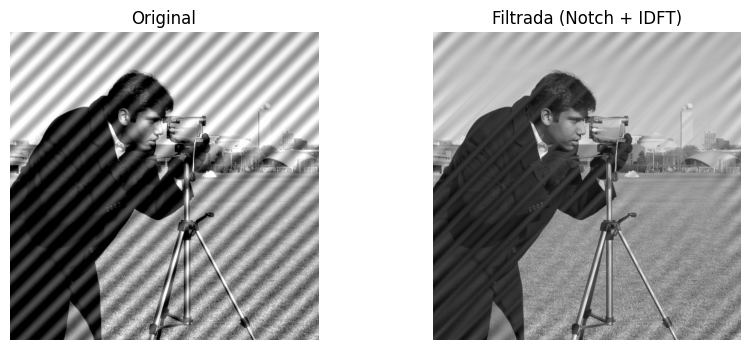

In [12]:

#  Filtrar en frecuencia 
F_filt = fourier_shift * mask

# Deshacer el shift y aplicar la inversa
F_ishift = np.fft.ifftshift(F_filt)
img_back = np.fft.ifft2(F_ishift)
img_back = np.real(img_back)  

# Normalizar y convertir a uint8
img_out = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_out = img_out.astype(np.uint8)

# Comparación
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(imagen_periodic, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_out, cmap='gray')
plt.title("Filtrada (Notch + IDFT)")
plt.axis('off')

plt.show()


### ¿Por qué un filtro de promedio 5×5 en el dominio espacial es una mala solución?

Un filtro promedio de 5x5 no seria una buena solución debido a que este es muy bueno para borrar o corregir ruido tipo sal o pimienta. En este caso como estamos trabajando con un ruido periodico y direccional el filtro promedio al corregir este ruido borraria detalles importantes de la imagen. Debido a que está usando el promedio de los vecinos y no sabe como tratar ruidos en frecuencias especificas como un filtro notch.  

## Task 2

Cargue la imagen fingerprint_noisy.png. Asegúrese de que sea binaria.

In [14]:
imagen_fingerprint = cv2.imread("fingerprint_noisy.png", cv2.IMREAD_GRAYSCALE)
_, imagen_binaria = cv2.threshold(imagen_fingerprint, 127, 255, cv2.THRESH_BINARY)

Aplique una operación morfológica para eliminar el ruido blanco sin destruir las crestas de la
huella. (Seleccione entre Erosión, Dilatación, Apertura o Cierre).

In [ ]:
# Se seleccionó Apertura para eliminar ruido
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
imagen_sin_ruido = cv2.morphologyEx(imagen_binaria, cv2.MORPH_OPEN, kernel_open)

Aplique una segunda operación secuencial para conectar las grietas en las crestas de la huella.

In [ ]:
# Se seleccionó Cierre para conectar crestas
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
imagen_final = cv2.morphologyEx(imagen_sin_ruido, cv2.MORPH_CLOSE, kernel_close)

Muestre la imagen original, la imagen tras el paso 2, y la imagen final.

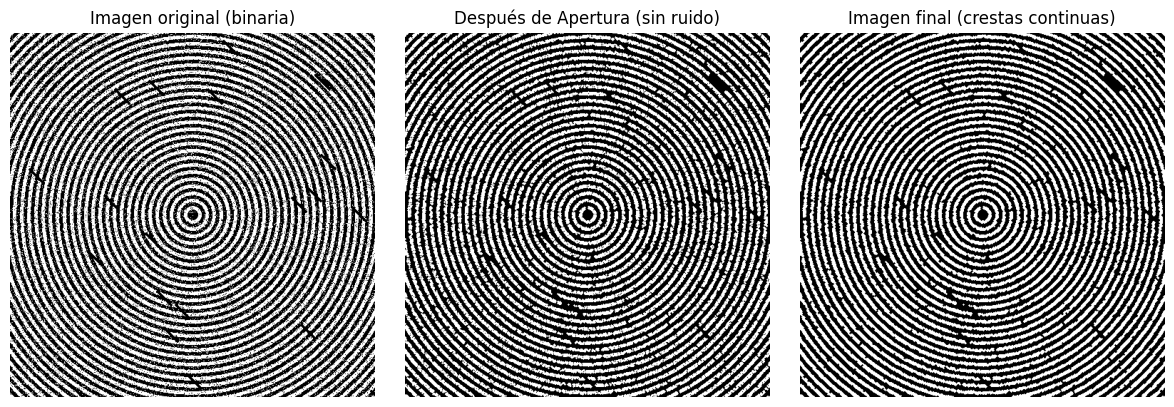

In [19]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(imagen_binaria, cmap="gray")
plt.title("Imagen original (binaria)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(imagen_sin_ruido, cmap="gray")
plt.title("Después de Apertura (sin ruido)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(imagen_final, cmap="gray")
plt.title("Imagen final (crestas continuas)")
plt.axis("off")

plt.tight_layout()
plt.show()

#### ¿El orden de los factores altera el producto? Explique qué hubiera pasado si hubiera aplicado las operaciones en orden inverso y demuéstrelo con un ejemplo visual en el notebook.

Sí, el orden de las operaciones morfológicas altera el resultado. Cuando aplicamos el cierre antes de la apertura, esto provoca que el ruido blanco se expanda y se integre a las crestas, dificultando su eliminación y disminuyendo la calidad de la huella.

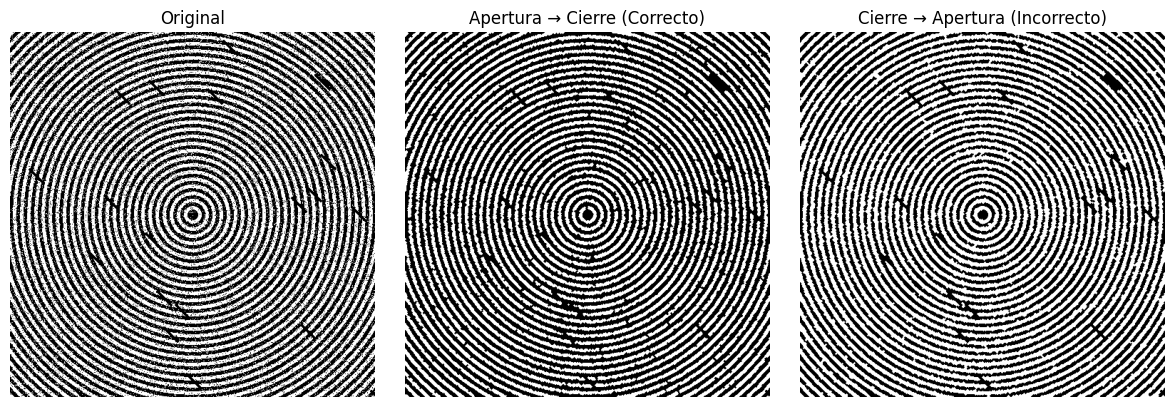

In [21]:
imagen_cierre = cv2.morphologyEx(imagen_binaria, cv2.MORPH_CLOSE, kernel_close)
imagen_final2 = cv2.morphologyEx(imagen_cierre, cv2.MORPH_OPEN, kernel_open)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(imagen_binaria, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(imagen_final, cmap="gray")
plt.title("Apertura → Cierre (Correcto)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(imagen_final2, cmap="gray")
plt.title("Cierre → Apertura (Incorrecto)")
plt.axis("off")

plt.tight_layout()
plt.show()

## Task 3

Carga de imagen

In [ ]:
imagen_textile = cv2.imread("textile_defect.jpg", cv2.IMREAD_GRAYSCALE)

Cálculo de transformada y shift

In [ ]:
imagen_t = imagen_textile.astype(np.float32)

transformada_fourier_t = np.fft.fft2(imagen_t)

fourier_shift_t = np.fft.fftshift(transformada_fourier_t)

Cálculo de valor logarítmica

In [ ]:
magnitud_t = np.abs(fourier_shift_t)

logaritmica_t = np.log(1+magnitud_t)

Visualización de espectro

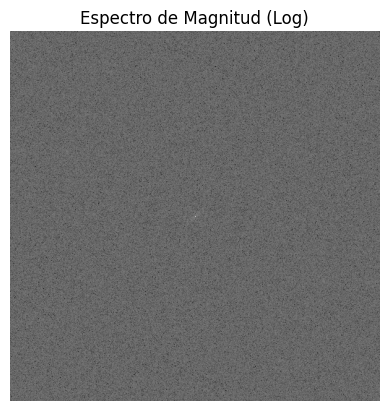

In [ ]:
log_view = cv2.normalize(logaritmica_t, None, 0, 255, cv2.NORM_MINMAX)
plt.imshow(log_view, cmap='gray')

plt.imshow(logaritmica_t, cmap='gray')
plt.title("Espectro de Magnitud (Log)")
plt.axis('off')
plt.show()


Creación de máscara Low-pass

In [ ]:
H, W = imagen_t.shape
cy, cx = H // 2, W // 2

Y, X = np.ogrid[:H, :W]
dist = np.sqrt((Y - cy)**2 + (X - cx)**2)

R = 55

mask_lp = dist <= R
mask_lp = mask_lp.astype(np.float32)


Visualización de máscara aplicada Low-pass

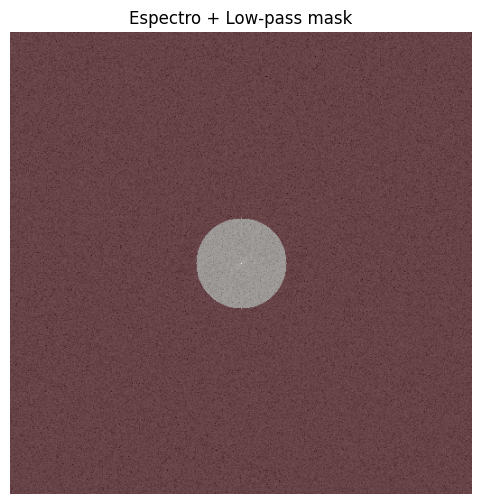

In [ ]:
blocked = 1 - mask_lp

plt.figure(figsize=(6,6))
plt.imshow(logaritmica_t, cmap='gray')
plt.imshow(blocked, cmap='Reds', alpha=0.35)
plt.title("Espectro + Low-pass mask")
plt.axis('off')
plt.show()


Regreso de la máscara Low-pass

In [ ]:
F_filt = fourier_shift_t * mask_lp

F_ishift = np.fft.ifftshift(F_filt)
img_smooth = np.fft.ifft2(F_ishift)
img_smooth = np.real(img_smooth)

img_smooth_u8 = cv2.normalize(img_smooth, None, 0, 255, cv2.NORM_MINMAX)
img_smooth_u8 = img_smooth_u8.astype(np.uint8)


Visualización de imagen suavizada

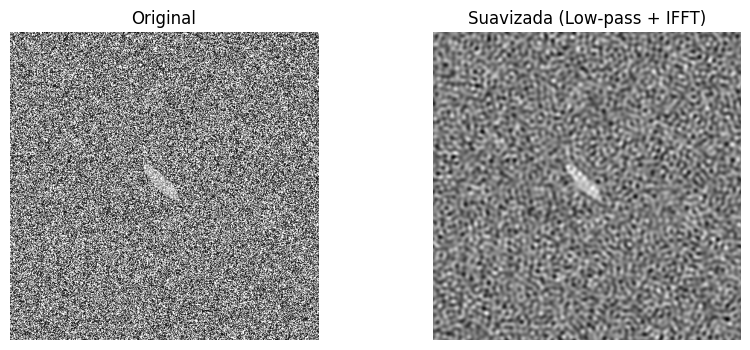

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(imagen_textile, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_smooth_u8, cmap='gray')
plt.title("Suavizada (Low-pass + IFFT)")
plt.axis('off')

plt.show()


Aplicación de threshold

In [ ]:
_, mask_thresh = cv2.threshold(
    img_smooth_u8,
    0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)


Visualización de máscara binaria

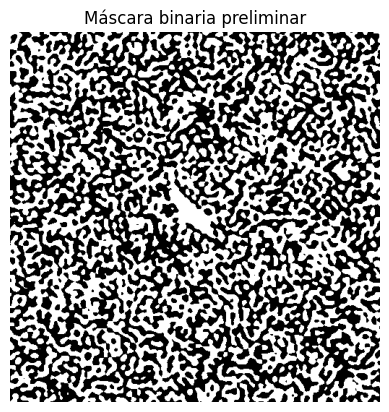

In [ ]:
plt.imshow(mask_thresh, cmap='gray')
plt.title("Máscara binaria preliminar")
plt.axis('off')
plt.show()


Procedimiento de opening y closing

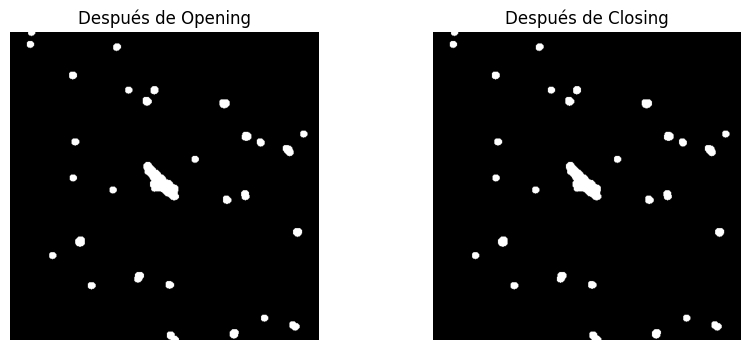

In [ ]:
k_o = 12
k_c = 3

kernel_o = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_o, k_o))
kernel_c = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_c, k_c))

mask_open = cv2.morphologyEx(mask_thresh, cv2.MORPH_OPEN, kernel_o)

mask_close = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_c)

# Visualización de opening y closing
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(mask_open, cmap='gray')
plt.title("Después de Opening")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_close, cmap='gray')
plt.title("Después de Closing")
plt.axis('off')
plt.show()

Eliminación de puntos solitarios

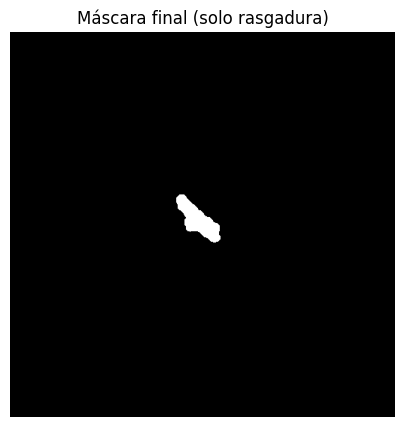

In [ ]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_close, connectivity=8)

final_mask = np.zeros_like(mask_close)

if num_labels > 1:  
    areas = stats[1:, cv2.CC_STAT_AREA]   
    largest_label = 1 + np.argmax(areas)
    final_mask[labels == largest_label] = 255

# Visualización de rasgadura
plt.figure(figsize=(5,5))
plt.imshow(final_mask, cmap='gray')
plt.title("Máscara final (solo rasgadura)")
plt.axis('off')
plt.show()

#### ¿Qué pasa si la rasgadura es muy pequeña? ¿Qué pasa si cambiamos el tipo de tela? ¿Es su solución robusta o específica para esta imagen?

La solución realizada es una combinación entre supresión de textura y conservación de anomalías, se hizo de esta manera porque ambos puntos son importantes para obtener un resultado existoso. Cuandoo la rasgadura es muy pequeña aunque estemos trabajando en el dominio de Fourier como la escala es muy pequeña esta se puede llegar a confundir con la textura del tejido, lo que hace que sea más complicado de detectar con existo. Si cambiamos el tipo de tela esto va a ocasionar cambios en las frecuencias de Fourier por lo tanto es posible que haya que cambiar el radio del filtro y en los parametros morfológicos. Debido a esto la solución no es robusta o universal, sino que depende de cada una de las texturas de la imagen porque habria que modificar los parametros utilizados para la detección de la rasgadura. 